In [10]:
!pip3 install -q http://download.pytorch.org/whl/cu90/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [0]:
# %matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage

import matplotlib.pyplot as plt

import numpy as np

import random
import datetime
import time


In [0]:
# CUSTOM FUNCTIONS
def newclass(trainset_gold,extraclass):

    trainset_new=trainset_gold.copy()
  
    elementsExtraClass=list(extraclass.values())[0] #numeber of element inside extra class
    
    elementsFromEachClass = int(round(len(elementsExtraClass) / len(trainset_gold.keys())))
        
    trainset_gold_balanced = []
    for k in trainset_gold.keys():
        myClassElements = trainset_gold[k]
        random.shuffle(myClassElements)
        trainset_gold_balanced += myClassElements[:elementsFromEachClass]
    
    
    dictForCNN = {}
    
    dictForCNN.update({'OLDtrainingset': []})
    dictForCNN.update({list(extraclass.keys())[0]: []})
        
    for i in trainset_gold_balanced:
        dictForCNN['OLDtrainingset'].append(i)
    for i in elementsExtraClass:
        dictForCNN[list(extraclass.keys())[0]].append(i)
    
    values, labels = returnValues(dictForCNN)
        
    return values, labels
    
    

def datasetBalancing(originalDict, nClassesToDrop):
    """
    This function has the purpose of balancing the dataset before using it in CNN.
    
    Starting from input data, we separate two distinct classes: one of the original classes
    extracted from the dataset that will act as a leaf (we call it 'class0'), and, excluding 
    the last step (consisting of only the two remaining classes) one "super" class containing 
    all the elements remaining (we call it 'class1')
    
    To keep the dataset balanced, we need the size of class0 to be equal to the size of class1. 
    In order to do that, we compute (based both on the size of class0 and the number of the 
    different classes in class1) the number of elements that have to be extracted from each
    subclass of class1 and we take them after reshuffling the elements to avoid taking
    always the same.
    
    :param (dictionary) originalDict: input dataset
    
    :return (dictionary) reducedDict: the input dataset with one class dropped
    :return (array) values: the values extracted from dataset
    :return (array) labels: the two key, one of one class and the key 'others' for the super class
    """
    tempDict = originalDict.copy()
    
    print("Start rebalancing: classes to drop = " + str(nClassesToDrop))
    for index in range(0, nClassesToDrop + 1):
      classToDrop = list(tempDict)[0]
      class0, tempDict = dropClass(tempDict, classToDrop)
      if len(tempDict.keys()) == 1:
        print("Last step: only 2 classes remaining")
      
        dictForCNN = {list(tempDict.keys())[0]: tempDict[list(tempDict.keys())[0]], classToDrop: class0}
        values, labels = returnValues(dictForCNN)
        return values, labels
      print('Class ' + str(classToDrop) + ' dropped')
      
    class1 = tempDict.copy()


    elementsFromEachClass = int(round(len(class0) / len(class1.keys())))
    
    print('We will take ' + str(elementsFromEachClass) + ' elements from each class ')
    
    class1_balanced = []
    for k in class1.keys():
        myClassElements = class1[k]
        random.shuffle(myClassElements)
        class1_balanced += myClassElements[:elementsFromEachClass]
    
    dictForCNN = {}
    
    dictForCNN.update({'others': []})
    dictForCNN.update({classToDrop: []})
        
    for i in class1_balanced:
        dictForCNN['others'].append(i)
    for i in class0:
        dictForCNN[classToDrop].append(i)
        
    values, labels = returnValues(dictForCNN)
        
    return values, labels

def dropClass(dictInput, className):
    """
    Function with the aim of dropping one class from a dictionary
    
    :param (dictionary) dictInput: the dictionary
    :param (string) className: the name of the class that has to be dropped from dictInput
    
    :return (array) class0: the elements contained in the dropped class
    :return (dictionary) class1: the remainig dictionary
    """
    return dictInput.pop(className), dictInput
    
    
def toDict(trainset, step):
    """
    Function with the goal of taking labels and data putting them in a dictionary.
    We take the data with its label and insert it into a dictionary: in the end, 
    we will have a dictionary with the different classes as keys and all the 
    data with that label as values.
    
    :param (dataset) trainset: the trainset
    
    :return (dictionary) returnDict: the resultant dictionary
    """
    
    if step == 0:
      labelsNotUsed = ['6', '9', '4', '1', '2', '7']
    else:
      labelsNotUsed = ['9', '4', '1', '2', '7']
    
    returnDict = {}
    
    for data, label in zip(trainset.data, trainset.targets):
        label = str(label)
        if label in labelsNotUsed:#deleate classes not used
          continue
        
        if label in returnDict.keys():
            returnDict[label].append(data)
        else:
            returnDict.update({label: []})
            returnDict[label].append(data)
            
    return returnDict
  
def dropElements(trainset):
    returnClass = {'6': []}
    
    for data, label in zip(trainset.data, trainset.targets):
        label = str(label)
        if label == '6':
          returnClass[label].append(data)
            
    return returnClass
  


def returnValues(dictInput):
    """
    Simply function that takes in input a dictionary and returns two array of values and labels before 
    passing them into the DataLoader
    
    :param (dictionary) dictInput: the input dictionary
    
    :return (array) values: all the values
    :return (array) labels: all the labels
    """
    
    values = np.array(list(dictInput.values())[0] + list(dictInput.values())[1])
    labels = [0]*len(list(dictInput.values())[0]) + [1]*len(list(dictInput.values())[1])
    
    return values, labels

def test_accuracy(tree, dataloader, originalDict):
  ########TESTING PHASE###########
    leaves = originalDict
    TotalClass = len(leaves)
    correct = 0
    total = 0
    net.eval() #important for deactivating dropout and correctly use batchnorm accumulated statistics
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            
            if labels not in leaves:
              continue
            
            images = images.cuda()   
            for i in range(0, TotalClass-1):
              
                labels_renamed=labels 
                if labels_renamed == leaves[i]:
                    labels_renamed = torch.tensor(1)

                else:
                    labels_renamed = torch.tensor(0)
                    

                labels_renamed = labels_renamed.cuda()  
                outputs =tree[i](images)  

                _, predicted = torch.max(outputs.data, 1)
                
                if predicted == 1:
                    class_predicted=leaves[i]
                    if class_predicted == labels:
                       correct=correct + 1
          
                    break
                else:
                  class_predicted=leaves[i+1]

            total += labels.size(0)
                
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: %d %%' % (accuracy))
    return accuracy

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Start rebalancing: classes to drop = 0
Class 8 dropped
We will take 1667 elements from each class 
[1,    39] loss: 0.602
[2,    39] loss: 0.472
[3,    39] loss: 0.418
[4,    39] loss: 0.376
[5,    39] loss: 0.359
0  graph


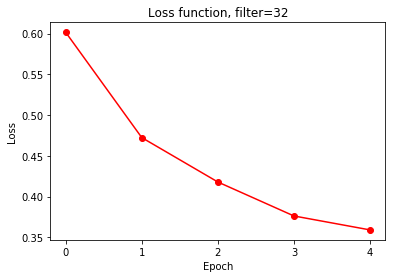

Start rebalancing: classes to drop = 1
Class 8 dropped
Class 3 dropped
We will take 2500 elements from each class 
[1,    39] loss: 0.636
[2,    39] loss: 0.585
[3,    39] loss: 0.566
[4,    39] loss: 0.550
[5,    39] loss: 0.544
1  graph


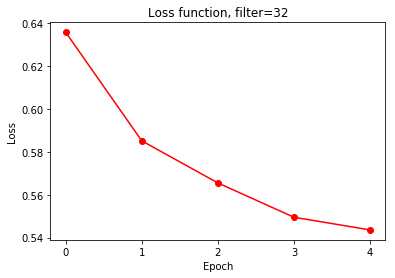

Start rebalancing: classes to drop = 2
Class 8 dropped
Class 3 dropped
Last step: only 2 classes remaining
[1,    39] loss: 0.529
[2,    39] loss: 0.294
[3,    39] loss: 0.237
[4,    39] loss: 0.223
[5,    39] loss: 0.213
2  graph


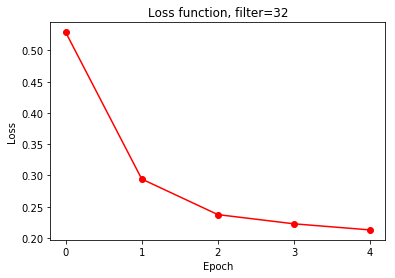

Accuracy of the network on the test set: 48 %


48.6

In [31]:
n_classes = 2       
start = time.time()     
#function to define the convolutional network
class CNN(nn.Module):
  def __init__(self):
        super(CNN, self).__init__()
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

  def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

      
#transform are heavily used to do simple and complex transformation and data augmentation
transform_train = transforms.Compose(
    [
     #transforms.RandomHorizontalFlip(),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

tree = [] #vector of nets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
trainset_gold=torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testsetnewclass = dropElements(testset)

testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                           shuffle=False, num_workers=4,drop_last=True)

newclassadd = dropElements(trainset_gold)

totalClasses = len(labelsArray) #number of classes

for j in range(0, 4-1):# totalClasses-1): #not any more used because deleate 5 elements
    
  trainset.data, trainset.targets = datasetBalancing(toDict(trainset_gold, 0), j)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                            shuffle=True, num_workers=4,drop_last=True)

  dataiter = iter(trainloader)

  net = CNN()
    
  net = net.cuda()

  criterion = nn.CrossEntropyLoss().cuda()
  optimizer = optim.Adam(net.parameters(), lr=0.0001) 

  ########TRAINING PHASE###########
  n_loss_print = len(trainloader) 
  loss_values = []
  n_epochs = 5
  
  for epoch in range(n_epochs):  # loop over the dataset multiple times
    net.train() #important for activating dropout and correctly train batchnorm
    
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
      # get the inputs and cast them into cuda wrapper
      inputs, labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % n_loss_print == (n_loss_print -1):    
          print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / n_loss_print))
          loss_values.append(running_loss / n_loss_print)
          running_loss = 0.0
              
  tree.append(net)
  epoch_values = np.arange(0, n_epochs, step = 1)
    
  print(j," graph")
  plt.title('Loss function, filter=32')
  plt.plot(loss_values, marker = 'o', color = 'red')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.xticks(epoch_values)

  plt.show()
  
test_accuracy(tree,testloader, [8,3,5,0])

Files already downloaded and verified
dict_keys(['6'])
[1,    39] loss: 0.600
[2,    39] loss: 0.528
[3,    39] loss: 0.506
[4,    39] loss: 0.496
[5,    39] loss: 0.487
graph


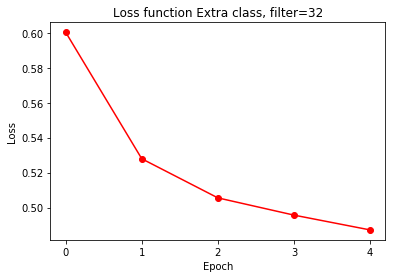

Accuracy of the network on the test set: 48 %
Execution time: 0:02:03.076351
Finished Training


In [32]:
####################new class##################################
trainset.data, trainset.targets = newclass(toDict(trainset_gold, 1), newclassadd)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                            shuffle=True, num_workers=4,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                           shuffle=False, num_workers=4,drop_last=True)

dataiter = iter(trainloader)

print(newclassadd.keys())

netExtra = CNN()
netExtra = netExtra.cuda()

criterion = nn.CrossEntropyLoss().cuda() 
optimizer = optim.Adam(netExtra.parameters(), lr=0.0001)
loss_values=[]
n_loss_print = len(trainloader)  

n_epochs = 5
for epoch in range(n_epochs):  # loop over the dataset multiple times
    netExtra.train() #important for activating dropout and correctly train batchnorm
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs and cast them into cuda wrapper
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = netExtra(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % n_loss_print == (n_loss_print -1):    
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / n_loss_print))
            loss_values.append(running_loss / n_loss_print)
            running_loss = 0.0

tree.insert(0,netExtra)
epoch_values = np.arange(0, n_epochs, step = 1)
    
print("graph")
plt.title('Loss function Extra class, filter=32')
plt.plot(loss_values, marker = 'o', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epoch_values)

plt.show()   

test_accuracy(tree,testloader, [6,8,3,5,0])
end = time.time()
print("Execution time: " + str(datetime.timedelta(seconds = end-start)))
print('Finished Training')